In [1]:
import statsmodels.api as sm
import yfinance as yf
from datetime import datetime
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
univ = [
    "BTC-USD", "ETH-USD", "BNB-USD", "XRP-USD",
    "ADA-USD", "DOGE-USD", "SOL-USD", "MATIC-USD",
    "DOT-USD", "LTC-USD"
]
px = yf.download(univ, start = '2020-01-01', end = '2024-12-31')
prices = px['Close']
rets = prices / prices.shift() - 1
vols = px['Volume']
highs = px['High']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


In [4]:
def weekly_mom_signals(prices, lookback):
    weekly_close = prices.resample('W-FRI').last()
    log_returns = np.log(weekly_close / weekly_close.shift(1))
    log_returns = log_returns.rolling(lookback, min_periods = 1).sum()
    signals = log_returns.reindex(prices.index)
    signals.fillna(method='ffill', inplace=True)
    signals.fillna(0, inplace=True)
    return signals

In [68]:
def weekly_hmom_signals(prices, highs, lookback):
    weekly_close = prices.resample('W-FRI').last()
    lnct = np.log(weekly_close)
    lnht = np.log(highs.rolling(lookback * 7, min_periods = 1).max())
    hmom = lnct - lnht.shift() # natural log of rolling high before this week's close
    signals = hmom.fillna(method='ffill')
    signals.fillna(0, inplace=True)
    return signals

In [54]:
def weekly_mmom_signals(prices, lookback):
    weekly_close = prices.resample('W-FRI').last()
    log_close = np.log(weekly_close)
    mean_log_close = log_close.rolling(lookback, min_periods = 1).mean()
    spread = log_close - mean_log_close.shift()
    signals = spread / spread.std()
    signals = signals.reindex(prices.index)
    signals.fillna(method='ffill', inplace=True)
    signals.fillna(0, inplace=True)
    return signals

In [25]:
def weekly_market_mom_signals(prices, lookback):
    weekly_close = prices.resample('W-FRI').last()
    log_close = np.log(weekly_close)
    log_returns = np.log(weekly_close / weekly_close.shift(1))
    log_returns = log_returns.rolling(lookback, min_periods = 1).sum()
    quantiles = log_returns.T.quantile(.67)
    aligned_quantiles = quantiles.reindex(log_returns.index)
    mask = log_returns.ge(aligned_quantiles, axis=0)
    signals = mask.astype(int).reindex(prices.index)
    signals.fillna(method='ffill', inplace=True)
    signals.fillna(0, inplace=True)
    return signals

In [67]:
def base_mom_weights(sigs):
    # Generate long only weights for each asset in sigs based on z-score signals
    # Input: signal df
    # Output: weights df
    weights = sigs[sigs > 0]
    weights = sigs.divide(sigs.abs().sum(1), 0)
    return weights

In [10]:
def portfolio(weights, rets):
    # Generate portfolio return based on weights and historical returns
    # Input: weights df, rets df
    # Output: portfolio return df of size (n_dates, 1)
    all_portfolio = (weights.shift() * rets).fillna(0)
    portfolio = all_portfolio.sum(1)
    return portfolio

In [11]:
def portfolio_turnover(weights):
    return np.abs(weights.shift() - weights).sum(1)

In [63]:
def weekly_mom_results(lookbacks):
    results = {}
    for lookback in lookbacks:
        sigs = weekly_mom_signals(prices, lookback)
        weights = base_mom_weights(sigs)
        port = portfolio(weights, rets)
        sharpe = port.mean() / port.std() * np.sqrt(252)
        turnover = portfolio_turnover(weights)
        tcost = 20 * 1e-4 * turnover
        tcost_port = port - tcost
        tcost_adj_sharpe = tcost_port.mean() / tcost_port.std() * np.sqrt(252)
        df = {}
        df['Ann. Ret'] = port.mean() * 252
        df['Ann. Vol'] = port.std() * np.sqrt(252)
        df['Ann. Sharpe'] = sharpe
        df['Avg. Tcost BPS'] = tcost.mean() * 10000
        df['Ann. Ret Post Tcosts'] = tcost_port.mean() * 252
        df['Ann. Sharpe Post Tcosts'] = tcost_adj_sharpe
        results[lookback] = df
    return pd.DataFrame(results).T
weekly_mom_results([1, 2, 3, 4, 6, 8, 10, 12, 26])

,Ann. Ret,Ann. Vol,Ann. Sharpe,Avg. Tcost BPS,Ann. Ret Post Tcosts,Ann. Sharpe Post Tcosts
1,0.343836,0.687261,0.500299,3.844748,0.246948,0.358878
2,0.609821,0.649790,0.938489,2.620483,0.543785,0.835917
3,0.934922,0.659718,1.417155,2.127183,0.881317,1.334671
4,0.974146,0.660542,1.474767,1.793074,0.928960,1.405590
6,0.623249,0.681400,0.914660,1.502130,0.585395,0.858827
8,0.543921,0.669009,0.813024,1.252280,0.512363,0.765646
10,0.555509,0.689247,0.805965,1.158847,0.526306,0.763374
12,0.517429,0.674953,0.766614,1.066324,0.490557,0.726728
26,0.605677,0.668335,0.906247,0.721965,0.587483,0.879076


In [64]:
def weekly_hmom_results(lookbacks):
    results = {}
    for lookback in lookbacks:
        sigs = weekly_hmom_signals(prices, highs, lookback)
        weights = base_mom_weights(sigs)
        port = portfolio(weights, rets)
        sharpe = port.mean() / port.std() * np.sqrt(252)
        turnover = portfolio_turnover(weights)
        tcost = 20 * 1e-4 * turnover
        tcost_port = port - tcost
        tcost_adj_sharpe = tcost_port.mean() / tcost_port.std() * np.sqrt(252)
        df = {}
        df['Ann. Ret'] = port.mean() * 252
        df['Ann. Vol'] = port.std() * np.sqrt(252)
        df['Ann. Sharpe'] = sharpe
        df['Avg. Tcost BPS'] = tcost.mean() * 10000
        df['Ann. Ret Post Tcosts'] = tcost_port.mean() * 252
        df['Ann. Sharpe Post Tcosts'] = tcost_adj_sharpe
        results[lookback] = df
    return pd.DataFrame(results).T
weekly_hmom_results([1, 2, 3, 4, 6, 8, 10, 12, 26])

,Ann. Ret,Ann. Vol,Ann. Sharpe,Avg. Tcost BPS,Ann. Ret Post Tcosts,Ann. Sharpe Post Tcosts
1,1.076295,0.843080,1.276623,0.431189,1.065429,1.264409
2,0.911570,0.781771,1.166032,0.357026,0.902573,1.155221
3,0.940614,0.793132,1.185949,0.281021,0.933532,1.177551
4,0.931925,0.790911,1.178293,0.251667,0.925583,1.170788
6,0.903394,0.788943,1.145068,0.234092,0.897494,1.138059
8,0.891374,0.786460,1.133399,0.190920,0.886563,1.127710
10,0.900410,0.790943,1.138400,0.173106,0.896047,1.133234
12,0.914086,0.788112,1.159843,0.164170,0.909949,1.154934
26,0.932487,0.797291,1.169569,0.130953,0.929187,1.165752


In [65]:
def weekly_mmom_results(lookbacks):
    results = {}
    for lookback in lookbacks:
        sigs = weekly_mmom_signals(prices, lookback)
        weights = base_mom_weights(sigs)
        port = portfolio(weights, rets)
        sharpe = port.mean() / port.std() * np.sqrt(252)
        turnover = portfolio_turnover(weights)
        tcost = 20 * 1e-4 * turnover
        tcost_port = port - tcost
        tcost_adj_sharpe = tcost_port.mean() / tcost_port.std() * np.sqrt(252)
        df = {}
        df['Ann. Ret'] = port.mean() * 252
        df['Ann. Vol'] = port.std() * np.sqrt(252)
        df['Ann. Sharpe'] = sharpe
        df['Avg. Tcost BPS'] = tcost.mean() * 10000
        df['Ann. Ret Post Tcosts'] = tcost_port.mean() * 252
        df['Ann. Sharpe Post Tcosts'] = tcost_adj_sharpe
        results[lookback] = df
    return pd.DataFrame(results).T
weekly_mmom_results([1, 2, 3, 4, 6, 8, 10, 12, 26])

,Ann. Ret,Ann. Vol,Ann. Sharpe,Avg. Tcost BPS,Ann. Ret Post Tcosts,Ann. Sharpe Post Tcosts
1,0.338240,0.654553,0.516750,3.839663,0.241481,0.368436
2,0.529484,0.632181,0.837552,2.878630,0.456943,0.721786
3,0.786525,0.628368,1.251695,2.366362,0.726892,1.155152
4,0.867499,0.630860,1.375104,2.050446,0.815827,1.291873
6,0.778078,0.624731,1.245461,1.688758,0.735521,1.176319
8,0.649752,0.637482,1.019248,1.457660,0.613019,0.961087
10,0.559919,0.645740,0.867096,1.344881,0.526028,0.814335
12,0.518112,0.644032,0.804482,1.255373,0.486477,0.755137
26,0.493385,0.644220,0.765865,0.843523,0.472129,0.732851


In [66]:
def weekly_market_mom_results(lookbacks):
    results = {}
    for lookback in lookbacks:
        sigs = weekly_market_mom_signals(prices, lookback)
        weights = base_mom_weights(sigs)
        port = portfolio(weights, rets)
        sharpe = port.mean() / port.std() * np.sqrt(252)
        turnover = portfolio_turnover(weights)
        tcost = 20 * 1e-4 * turnover
        tcost_port = port - tcost
        tcost_adj_sharpe = tcost_port.mean() / tcost_port.std() * np.sqrt(252)
        df = {}
        df['Ann. Ret'] = port.mean() * 252
        df['Ann. Vol'] = port.std() * np.sqrt(252)
        df['Ann. Sharpe'] = sharpe
        df['Avg. Tcost BPS'] = tcost.mean() * 10000
        df['Ann. Ret Post Tcosts'] = tcost_port.mean() * 252
        df['Ann. Sharpe Post Tcosts'] = tcost_adj_sharpe
        results[lookback] = df
    return pd.DataFrame(results).T
weekly_market_mom_results([1, 2, 3, 4, 6, 8, 10, 12, 26])

,Ann. Ret,Ann. Vol,Ann. Sharpe,Avg. Tcost BPS,Ann. Ret Post Tcosts,Ann. Sharpe Post Tcosts
1,1.016295,0.764258,1.329781,3.702081,0.923003,1.207693
2,1.119793,0.776167,1.442722,2.511866,1.056494,1.361025
3,1.111039,0.774762,1.434039,2.081051,1.058597,1.366312
4,1.048969,0.789158,1.329225,1.854691,1.002230,1.270067
6,1.069916,0.900007,1.188787,1.474991,1.032747,1.147530
8,1.145131,0.907425,1.261957,1.219423,1.114401,1.228336
10,1.034646,0.903758,1.144827,1.080686,1.007413,1.114795
12,1.103794,0.912208,1.210025,1.087988,1.076377,1.179993
26,0.842943,0.763824,1.103583,0.693684,0.825462,1.080884


In [27]:
btc_ret = rets['BTC-USD']

In [28]:
base_sigs = weekly_mom_signals(prices, 4)
base_weights = base_mom_weights(base_sigs)
mom_port = portfolio(base_weights, rets)

In [29]:
hmom_sigs = weekly_hmom_signals(prices, highs, 1)
hmom_weights = base_mom_weights(hmom_sigs)
hmom_port = portfolio(hmom_weights, rets)

In [30]:
mmom_sigs = weekly_mmom_signals(prices, 4)
mmom_weights = base_mom_weights(mmom_sigs)
mmom_port = portfolio(mmom_weights, rets)

In [31]:
marketmom_sigs = weekly_market_mom_signals(prices, 4)
marketmom_weights = base_mom_weights(marketmom_sigs)
marketmom_port = portfolio(marketmom_weights, rets)

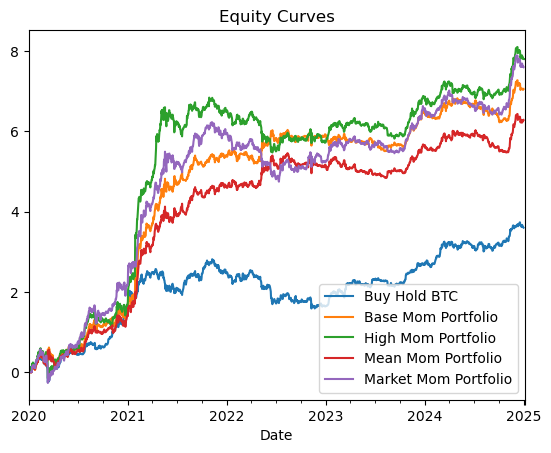

In [52]:
btc_ret.cumsum().plot(label='Buy Hold BTC')
mom_port.cumsum().plot(label='Base Mom Portfolio')
hmom_port.cumsum().plot(label='High Mom Portfolio')
mmom_port.cumsum().plot(label='Mean Mom Portfolio')
marketmom_port.cumsum().plot(label='Market Mom Portfolio')
plt.title('Equity Curves')
plt.legend()

In [49]:
all_results = {}
ann_alphas = {}
strat_ports = {
    'Base Mom': mom_port,
    'High Mom': hmom_port,
    'Mean Mom': mmom_port,
    'Market Mom': marketmom_port
}

X = sm.add_constant(pd.Series(rets['BTC-USD'], name='Buy & Hold Coins'))

for name, port in strat_ports.items():
    y = pd.Series(port, name=name)
    X, y = X.fillna(0), y.fillna(0)
    X, y = X.align(y, join='inner', axis=0)
    model = sm.OLS(y, X).fit()

    alpha = model.params['const']
    beta = model.params[1]

    results_dict = {
        'alpha': alpha,
        'beta': beta,
        'r_squared': model.rsquared,
        'adj_r_squared': model.rsquared_adj,
        'alpha_pval': model.pvalues['const'],
        'beta_pval': model.pvalues[1],
        'alpha_tval': model.tvalues['const'],
        'beta_tval': model.tvalues[1],
        'std_err_alpha': model.bse['const'],
        'std_err_beta': model.bse[1],
        'n_obs': int(model.nobs),
        'f_statistic': model.fvalue,
        'f_pvalue': model.f_pvalue
    }
    ann_alphas[name] = alpha * 252
    all_results[name] = results_dict

test_stats = pd.DataFrame(all_results).T.round(4)
test_stats

,alpha,beta,r_squared,adj_r_squared,alpha_pval,beta_pval,alpha_tval,beta_tval,std_err_alpha,std_err_beta,n_obs,f_statistic,f_pvalue
Base Mom,0.0036,0.1355,0.0119,0.0114,0.0002,0.0000,3.7100,4.6948,0.0010,0.0289,1826.0,22.0409,0.0000
High Mom,0.0021,1.1104,0.4916,0.4913,0.0192,0.0000,2.3446,41.9969,0.0009,0.0264,1826.0,1763.7367,0.0000
Mean Mom,0.0033,0.0680,0.0033,0.0027,0.0004,0.0142,3.5561,2.4541,0.0009,0.0277,1826.0,6.0228,0.0142
Market Mom,0.0020,1.0901,0.5410,0.5408,0.0109,0.0000,2.5474,46.3706,0.0008,0.0235,1826.0,2150.2286,0.0000
